# Empirical Results - Word2Vec and SBERT Clustering

## Required Libraries

In [1]:
from clustering_utility import *

import os
from pathlib import Path
import json
import pickle
from tqdm import tqdm
import pandas as pd
import numpy as np
import networkx as nx

import matplotlib.pylab as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.cluster import MeanShift
import umap

pd.set_option('display.max_colwidth', None)
output_to_cm_font = False # set font of plot outputs
if output_to_cm_font:
    from matplotlib import rc
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    # rc('text', usetex=True)

## Data Preparation

In [2]:
# Please note that both TSNE(sklearn) and UMAP will produce different result
# on different operating system (Linux, MacOS, Windows, etc.) even with the same seed and same dependencies version.
# This is a known issue with the underlying libraries numba.
# The original results was produced on Windows 11 

# seed = 9 is used for all part of the project for consistency
seed = 9

In [3]:
time_range = list(range(2013,2023))
min_sentence_len_to_collect = 5
firm_list = os.listdir(Path("../../report_data"))
try:
    firm_list.remove(".DS_Store")
except:
    pass
firm_list.sort()
firm_to_index_map = {firm_list[i]:i for i in range(len(firm_list))}
index_to_firm_map = {i:firm_list[i] for i in range(len(firm_list))}

In [4]:
# load model metadata and sbert encoded data

# sbert
with open(Path("../../embedding_data/sbert/sbert_model_metadata_all_mpnet_base_v2.json"), 'r') as f:
    SBERT_model_metadata_all_mpnet_base_v2 = json.load(f)
with open(Path("../../embedding_data/sbert/sbert_encoded_text_normalised_data_all_mpnet_base_v2.pkl"), 'rb') as f:
    sbert_encoded_text_normalised_data_dict = pickle.load(f)

# w2v
with open(Path("../../embedding_data/w2v/w2v_runs/sgns_global_replacement/data_and_model_config.json"), 'r') as f:
    w2v_data_and_model_config = json.load(f)
with open(Path("../../embedding_data/w2v/w2v_runs/sgns_global_replacement/w2v_embedding_firm_token_only.pkl"), 'rb') as f:
    w2v_embedding_firm_token_only = pickle.load(f)


# Word2Vec

## Word2Vec Embedding Clusters via Statistical Method

### Dimensionality Reduction

#### t-SNE

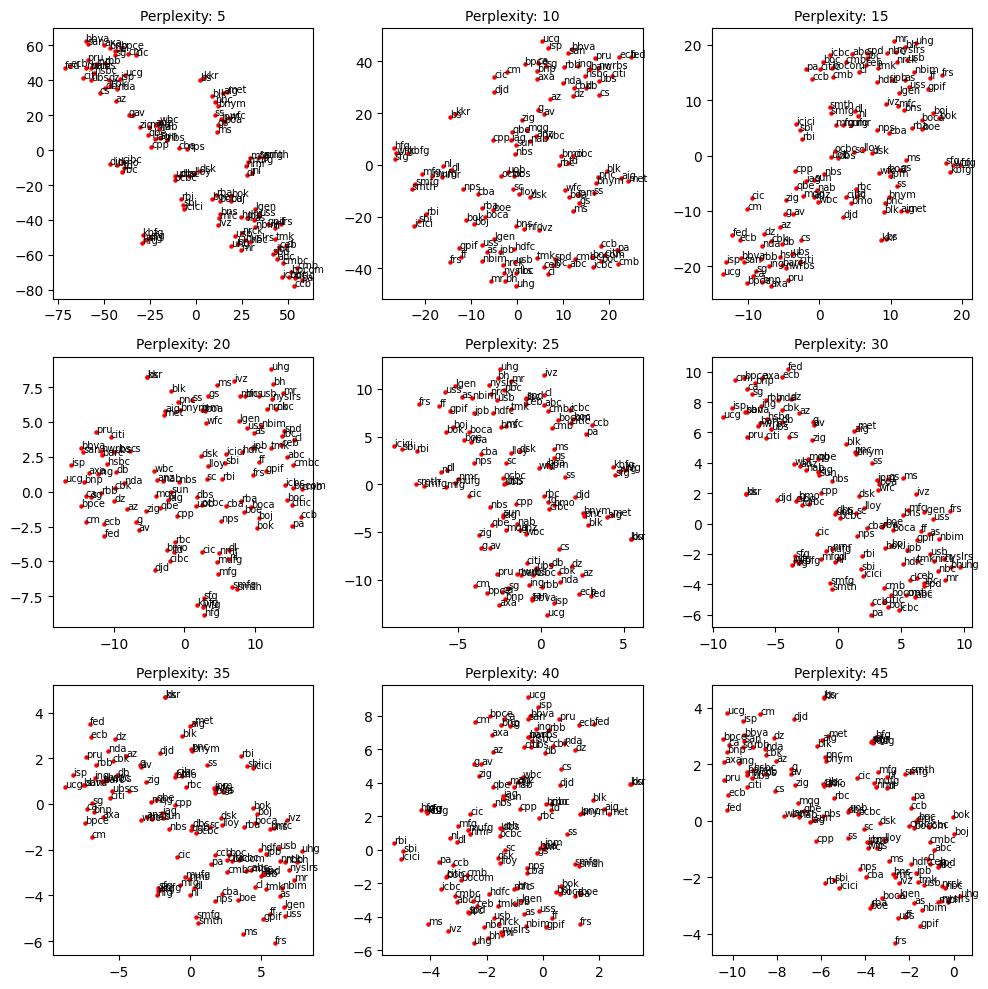

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
tsne_perplexity_values = [5, 10, 15, 20, 25, 30, 35, 40, 45]

for ax, tsne_perplexity_values in zip(axes.flatten(), tsne_perplexity_values):
    tsne_reducer = TSNE(
        n_components=2,
        perplexity=tsne_perplexity_values,
        max_iter=5000,
        random_state=seed,
        early_exaggeration=12.0,
    )
    w2v_tsne_reduced = tsne_reducer.fit_transform(w2v_embedding_firm_token_only)

    ax.scatter(
        w2v_tsne_reduced[:, 0],
        w2v_tsne_reduced[:, 1],
        c="red",
        alpha=1,
        s=5,
    )
    for i, txt in enumerate(firm_list):
        ax.annotate(
            text=txt,
            xy=(w2v_tsne_reduced[:, 0][i] + 0, w2v_tsne_reduced[:, 1][i] + 0),
            fontsize=7,
        )
    ax.set_title(f"Perplexity: {tsne_perplexity_values}", fontsize=10)
    # ax.grid()

plt.tight_layout()
plt.savefig(
    Path("../../../tex_source/plots/plots_appendix/w2v_d_reduc_tsne.pdf"), format="pdf"
)
plt.show()

#### UMAP

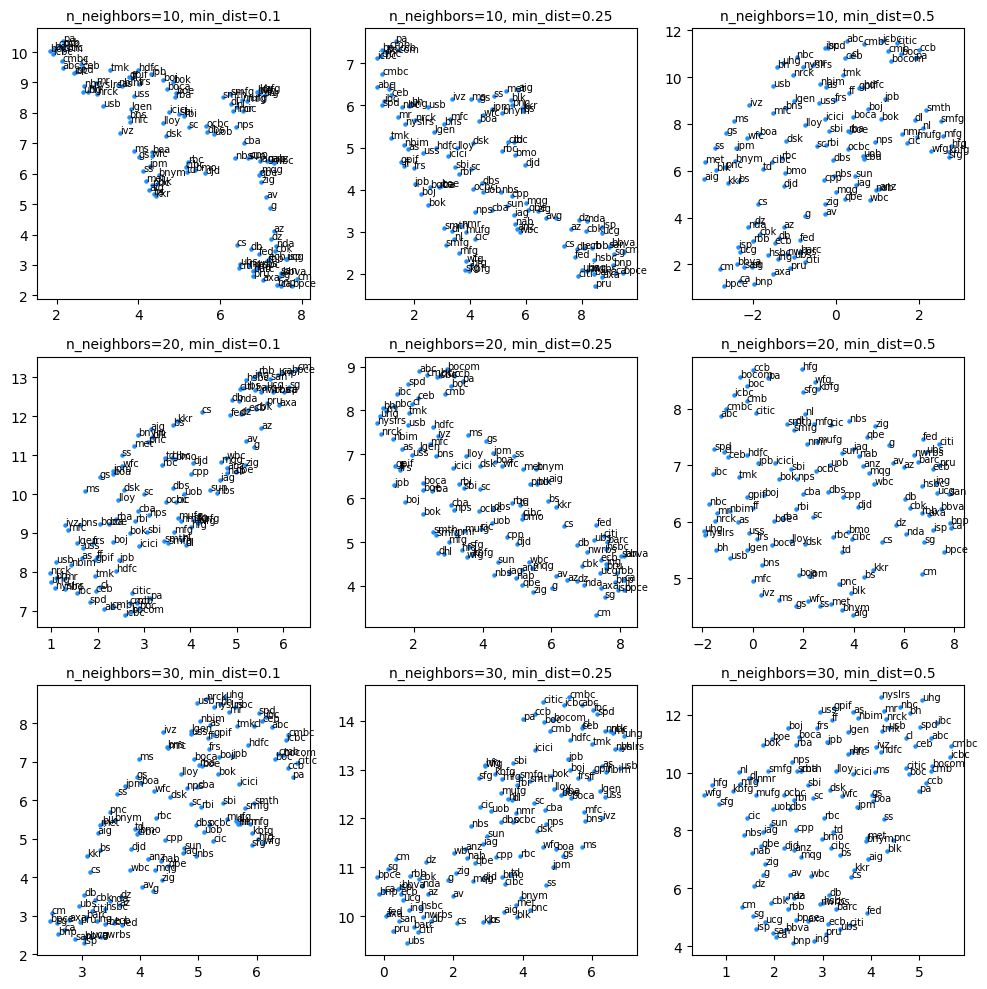

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
umap_n_neighbors = [10, 20, 30]
umap_min_dist = [0.1, 0.25, 0.5]
umap_parameter_values = [(n, d) for n in umap_n_neighbors for d in umap_min_dist]

for ax, umap_parameter_values in zip(axes.flatten(), umap_parameter_values):
    umap_reducer = umap.UMAP(
        n_neighbors=umap_parameter_values[0],
        min_dist=umap_parameter_values[1],
        n_components=2,
        random_state=np.random.RandomState(9),
        n_jobs=1,
    )
    w2v_umap_reduced = umap_reducer.fit_transform(w2v_embedding_firm_token_only)

    ax.scatter(
        w2v_umap_reduced[:, 0],
        w2v_umap_reduced[:, 1],
        c="dodgerblue",
        alpha=1,
        s=5,
    )

    for i, txt in enumerate(firm_list):
        ax.annotate(
            text=txt,
            xy=(w2v_umap_reduced[:, 0][i] + 0, w2v_umap_reduced[:, 1][i] + 0),
            fontsize=7,
        )

    ax.set_title(
        f"n_neighbors={umap_parameter_values[0]}, min_dist={umap_parameter_values[1]}",
        fontsize=10,
    )
    # ax.grid().

plt.tight_layout()
plt.savefig(
    Path("../../../tex_source/plots/plots_appendix/w2v_d_reduc_umap.pdf"), format="pdf"
)
plt.show()

### Word2Vec MeanShift Clustering with UMAP

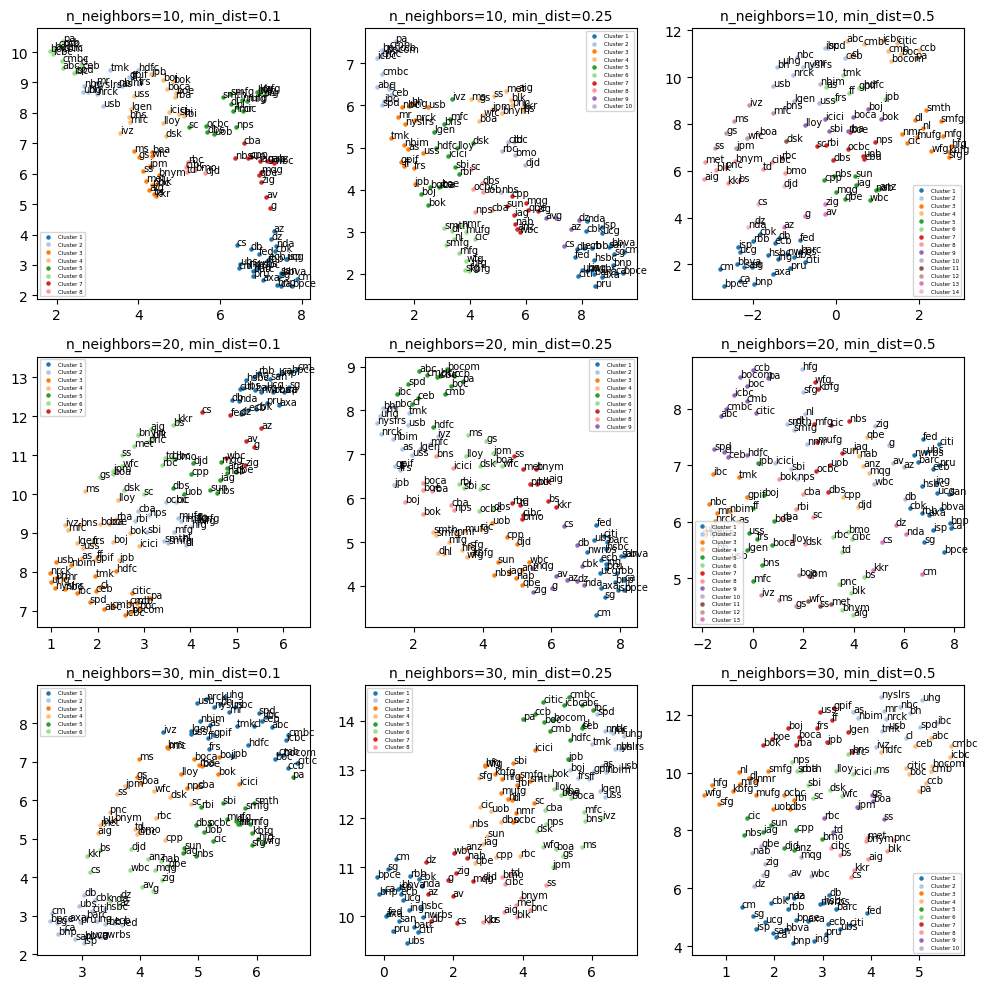

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
umap_n_neighbors = [10, 20, 30]
umap_min_dist = [0.1, 0.25, 0.5]
umap_parameter_values = [(n, d) for n in umap_n_neighbors for d in umap_min_dist]

for ax, umap_parameter_values in zip(axes.flatten(), umap_parameter_values):
    umap_reducer = umap.UMAP(
        n_neighbors=umap_parameter_values[0],
        min_dist=umap_parameter_values[1],
        n_components=2,
        random_state=seed,
        n_jobs=1,
    )
    w2v_umap_reduced = umap_reducer.fit_transform(w2v_embedding_firm_token_only)
    meanshift_w2v_umap = MeanShift(bandwidth=1, cluster_all=True).fit(w2v_umap_reduced)
    labels_meanshift_w2v_umap = meanshift_w2v_umap.labels_

    unique_labels = np.unique(labels_meanshift_w2v_umap)
    cmap = plt.get_cmap('tab20')
    for color_idx, label in enumerate(unique_labels):
        idx = [i for i, val in enumerate(labels_meanshift_w2v_umap) if val == label]
        ax.scatter(
        w2v_umap_reduced[idx, 0],
        w2v_umap_reduced[idx, 1],
        color=cmap(color_idx),
        label=f"Cluster {label+1}",
        alpha=1,
        s=5)

    for i, txt in enumerate(firm_list):
        ax.annotate(
            text=txt,
            xy=(w2v_umap_reduced[:, 0][i] + 0, w2v_umap_reduced[:, 1][i] + 0),
            fontsize=7,
        )

    ax.set_title(
        f"n_neighbors={umap_parameter_values[0]}, min_dist={umap_parameter_values[1]}",
        fontsize=10,
    )
    ax.legend(prop = { "size": 4}, loc ="best")
    # ax.grid().

plt.tight_layout()
plt.savefig(
    Path("../../../tex_source/plots/plots_result/w2v_d_reduc_umap_meanshift.pdf"), format="pdf"
)
plt.show()

### Word2Vec MeanShift Clustering with UMAP: Best Result

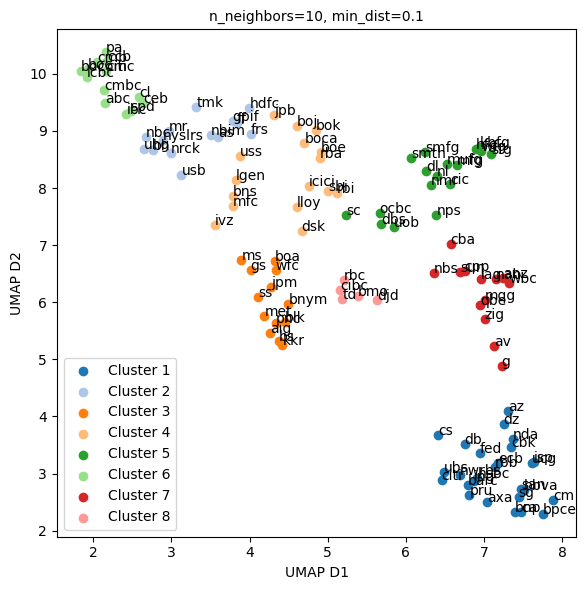

{'Cluster 1': 'axa, az, barc, bbva, bnp, bpce, ca, cbk, citi, cm, cs, db, dz, ecb, fed, hsbc, ing, isp, nda, nwrbs, pru, rbb, san, sg, ubs, ucg',
 'Cluster 2': 'as, bh, ff, frs, gpif, hdfc, mr, nbc, nbim, nrck, nyslrs, tmk, uhg, usb',
 'Cluster 3': 'aig, blk, bnym, boa, bs, gs, jpm, kkr, met, ms, pnc, ss, wfc',
 'Cluster 4': 'bns, boca, boe, boj, bok, dsk, icici, ivz, jpb, lgen, lloy, mfc, rba, rbi, sbi, uss',
 'Cluster 5': 'cic, dbs, dl, hfg, kbfg, mfg, mufg, nl, nmr, nps, ocbc, sc, sfg, smfg, smth, uob, wfg',
 'Cluster 6': 'abc, boc, bocom, ccb, ceb, citic, cl, cmb, cmbc, ibc, icbc, pa, spd',
 'Cluster 7': 'anz, av, cba, cpp, g, iag, mqg, nab, nbs, qbe, sun, wbc, zig',
 'Cluster 8': 'bmo, cibc, djd, rbc, td'}

In [8]:
best_n_neighbors = 10
best_min_dist = 0.1

umap_reducer = umap.UMAP(
    n_neighbors=best_n_neighbors,
    min_dist=best_min_dist,
    n_components=2,
    random_state=seed,
    n_jobs=1,
)
w2v_umap_reduced = umap_reducer.fit_transform(w2v_embedding_firm_token_only)
meanshift_w2v_umap = MeanShift(bandwidth=1, cluster_all=True).fit(w2v_umap_reduced)
labels_meanshift_w2v_umap = meanshift_w2v_umap.labels_

plt.figure(figsize=(6, 6))
ax = plt.gca()
unique_labels = np.unique(labels_meanshift_w2v_umap)
cmap = plt.get_cmap("tab20")
meanshift_w2v_umap_best_cluster_result = {}
for color_idx, label in enumerate(unique_labels):
    idx = [i for i, val in enumerate(labels_meanshift_w2v_umap) if val == label]
    meanshift_w2v_umap_best_cluster_result[f"Cluster {label+1}"] = idx
    ax.scatter(
        w2v_umap_reduced[idx, 0],
        w2v_umap_reduced[idx, 1],
        color=cmap(color_idx),
        label=f"Cluster {label+1}",
    )

for i, txt in enumerate(firm_list):
    ax.annotate(txt, (w2v_umap_reduced[:, 0][i] + 0, w2v_umap_reduced[:, 1][i] + 0))

plt.title(
        f"n_neighbors={best_n_neighbors}, min_dist={best_min_dist}",
        fontsize=10,)
plt.legend()
plt.xlabel("UMAP D1")
plt.ylabel("UMAP D2")
plt.tight_layout()
plt.savefig(
    Path("../../../tex_source/plots/plots_result/w2v_d_reduc_umap_meanshift_best.pdf"), format="pdf"
)
plt.show()

for cluster in meanshift_w2v_umap_best_cluster_result.keys():
    meanshift_w2v_umap_best_cluster_result[cluster] = [index_to_firm_map[firm_idx] for firm_idx in meanshift_w2v_umap_best_cluster_result[cluster]] 

meanshift_w2v_umap_best_cluster_result_joined={}
for cluster in meanshift_w2v_umap_best_cluster_result.keys():
    meanshift_w2v_umap_best_cluster_result_joined[cluster] = ", ".join(meanshift_w2v_umap_best_cluster_result[cluster])
meanshift_w2v_umap_best_cluster_result_joined

In [9]:
meanshift_w2v_umap_best_cluster_result_df = pd.DataFrame.from_dict(
    meanshift_w2v_umap_best_cluster_result_joined, orient="index"
)
meanshift_w2v_umap_best_cluster_result_df.reset_index(inplace=True)
meanshift_w2v_umap_best_cluster_result_df.columns = ["Cluster", "Financial Institution"]
meanshift_w2v_umap_best_cluster_result_df

meanshift_w2v_umap_best_cluster_result_df.style.hide().format(na_rep="").set_table_styles([
    {'selector': 'small', 'props': ':;'}], overwrite=False).to_latex(
    buf="../../../tex_source/tables/tables_result/meanshift_w2v_umap_best_cluster_result_table.tex",
    caption="Word2Vec Mean Shift Clustering (UMAP) Best Result Table",
    label="tab:meanshift_w2v_umap_best_cluster_result_table",
    encoding="utf-8",
    hrules=True,
    position_float="centering",
    position="H",
    column_format="lp{15cm}",
)
# {'selector': 'small', 'props': ':;'}
# {'selector': 'fontsize', 'props': ':{11pt}{13pt}\selectfont;'}

## Word2Vec Embedding Clusters via Network-Based Method

### Word2Vec Louvain Community Detection

In [10]:
w2v_cosine_similarity_matrix = compute_cosine_similarity_matrix(w2v_embedding_firm_token_only)
w2v_cosine_similarity_matrix_exp_scaled = exp_scale_to_df(w2v_cosine_similarity_matrix, firm_list)
w2v_cosine_similarity_matrix = pd.DataFrame(w2v_cosine_similarity_matrix, columns=firm_list, index=firm_list) # for embedding comparison later

w2v_cosine_similarity_G_weighted = create_weighted_graph_from_df(w2v_cosine_similarity_matrix_exp_scaled)

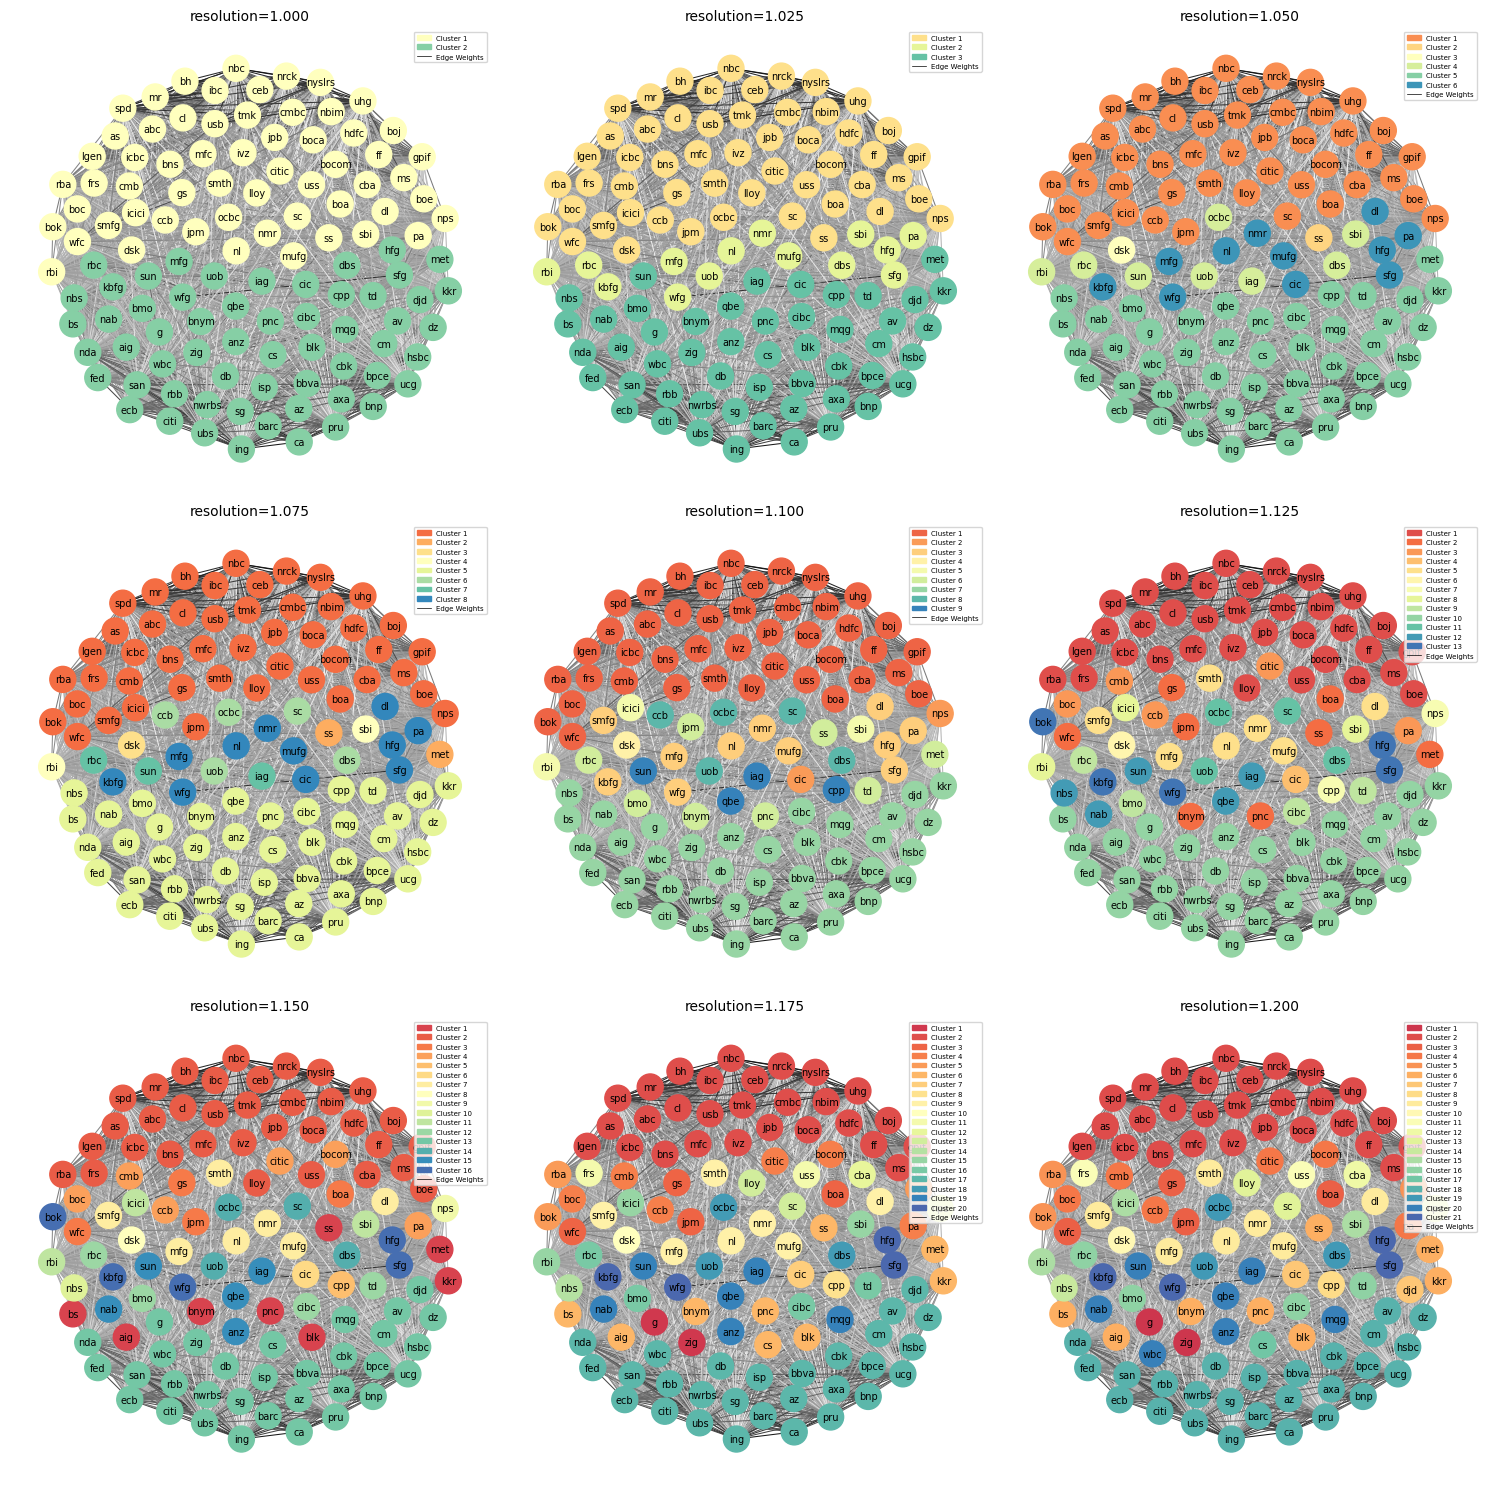

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

resolution_values = np.linspace(1, 1.20, 9)

# different louvain_communities resolution values plot
for ax, resolution in zip(axes.flatten(), resolution_values):
    w2v_louvain_communities = nx.community.louvain_communities(w2v_cosine_similarity_G_weighted, weight="weight", seed=seed, resolution=resolution)
    edge_weights_dict = nx.get_edge_attributes(w2v_cosine_similarity_G_weighted, 'weight')
    weights = [edge_weights_dict[edge] for edge in w2v_cosine_similarity_G_weighted.edges()]
    
    num_communities = len(w2v_louvain_communities)
    exclude_first_n_color = 2
    colors = [
        plt.cm.Spectral(i / (num_communities + exclude_first_n_color))
        for i in range(num_communities + exclude_first_n_color)
    ][
        exclude_first_n_color : num_communities + exclude_first_n_color
    ]  # Create a color map for the communities, adjusted to exclude the first n color (too dark)

    # Create a dictionary to map nodes to their community colors
    node_color_map = {}
    w2v_louvain_communities_with_color_and_label = {}
    for community_index, community in enumerate(w2v_louvain_communities):
        w2v_louvain_communities_with_color_and_label[f"Cluster {community_index+1}"] = {"color": colors[community_index], "nodes": community}
        for node in community:
            node_color_map[node] = colors[community_index]
    node_colors = [node_color_map[node] for node in w2v_cosine_similarity_G_weighted.nodes()]

    # Generate layout for the graph
    pos = nx.spring_layout(w2v_cosine_similarity_G_weighted, seed=seed, iterations=5000, threshold=1e-9)
    
    # Plot the graph
    nx.draw(
        w2v_cosine_similarity_G_weighted,
        pos,
        with_labels=True,
        node_size=350,
        node_color=node_colors,
        font_size=7,
        font_weight="normal",
        font_color="black",
        edge_color=weights,
        edge_cmap=plt.cm.binary,
        width=0.75,
        ax=ax
    )

    patches = [mpatches.Patch(color=color['color'], label=label) for label, color in w2v_louvain_communities_with_color_and_label.items()]
    edge_line = mlines.Line2D([], [], color='black', linewidth=0.5, label='Edge Weights') # add edge weight line to legend

    ax.legend(handles=patches+[edge_line], prop={"size": 5}, loc="upper right")
    ax.set_title(f"resolution={resolution:.3f}", fontsize=10)

plt.tight_layout()
plt.savefig(
    Path("../../../tex_source/plots/plots_result/w2v_network_louvain.pdf"), format="pdf"
)
plt.show()

### Word2Vec Louvain Community Detection: Best Result

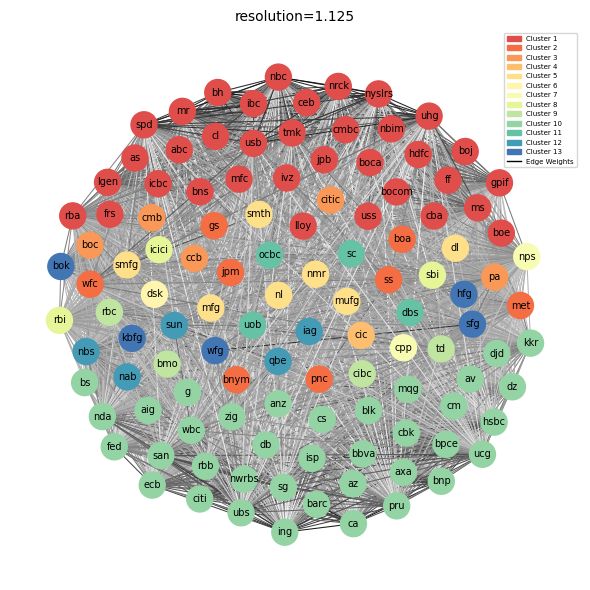

{'Cluster 1': 'ibc, ivz, mfc, mr, uhg, gpif, ms, boe, lgen, cba, boj, bocom, jpb, nbc, spd, nbim, hdfc, as, tmk, bh, uss, usb, bns, icbc, rba, nyslrs, nrck, cl, ceb, cmbc, boca, ff, frs, lloy, abc',
 'Cluster 2': 'jpm, boa, pnc, ss, wfc, bnym, gs, met',
 'Cluster 3': 'cmb, pa, boc, ccb, citic',
 'Cluster 4': 'cic',
 'Cluster 5': 'nmr, smfg, mufg, smth, mfg, dl, nl',
 'Cluster 6': 'dsk',
 'Cluster 7': 'nps, cpp',
 'Cluster 8': 'icici, sbi, rbi',
 'Cluster 9': 'cibc, td, rbc, bmo',
 'Cluster 10': 'ca, pru, wbc, ing, cbk, db, av, san, djd, bs, blk, barc, nwrbs, isp, bbva, sg, bnp, nda, g, mqg, dz, aig, cm, axa, hsbc, fed, rbb, ucg, bpce, ecb, az, citi, cs, kkr, anz, ubs, zig',
 'Cluster 11': 'uob, ocbc, sc, dbs',
 'Cluster 12': 'iag, nbs, nab, qbe, sun',
 'Cluster 13': 'bok, kbfg, sfg, hfg, wfg'}

In [12]:
best_resolution = 1.125

w2v_louvain_best_communities = nx.community.louvain_communities(w2v_cosine_similarity_G_weighted, weight="weight", seed=seed, resolution=best_resolution)
edge_weights_dict = nx.get_edge_attributes(w2v_cosine_similarity_G_weighted, 'weight')
weights = [edge_weights_dict[edge] for edge in w2v_cosine_similarity_G_weighted.edges()]

w2v_louvain_best_num_communities = len(w2v_louvain_best_communities)
exclude_first_n_color = 2
colors = [
    plt.cm.Spectral(i / (w2v_louvain_best_num_communities + exclude_first_n_color))
    for i in range(w2v_louvain_best_num_communities + exclude_first_n_color)
][
    exclude_first_n_color : w2v_louvain_best_num_communities + exclude_first_n_color
]  # Create a color map for the communities, adjusted to exclude the first n color (too dark)

# Create a dictionary to map nodes to their community colors
node_color_map = {}
w2v_louvain_best_communities_with_color_and_label = {}
for community_index, community in enumerate(w2v_louvain_best_communities):
    w2v_louvain_best_communities_with_color_and_label[f"Cluster {community_index+1}"] = {"color": colors[community_index], "nodes": community}
    for node in community:
        node_color_map[node] = colors[community_index]
node_colors = [node_color_map[node] for node in w2v_cosine_similarity_G_weighted.nodes()]

# Generate layout for the graph
pos = nx.spring_layout(w2v_cosine_similarity_G_weighted, seed=seed, iterations=5000, threshold=1e-9)

# Plot the graph
plt.figure(figsize=(6, 6))
nx.draw(
    w2v_cosine_similarity_G_weighted,
    pos,
    with_labels=True,
    node_size=350,
    node_color=node_colors,
    font_size=7,
    font_weight="normal",
    font_color="black",
    edge_color=weights,
    edge_cmap=plt.cm.binary,
    width=0.75,
    ax=plt.gca()
)

patches = [mpatches.Patch(color=color['color'], label=label) for label, color in w2v_louvain_best_communities_with_color_and_label.items()]
edge_line = mlines.Line2D([], [], color='black', linewidth=1, label='Edge Weights') # add edge weight line to legend

plt.legend(handles=patches+[edge_line], prop={"size": 5}, loc="upper right")
plt.title(f"resolution={best_resolution}", fontsize=10)
plt.tight_layout()
plt.savefig(
Path("../../../tex_source/plots/plots_result/w2v_network_louvain_best.pdf"), format="pdf"
)
plt.show()

louvain_w2v_best_cluster_result = {key: value['nodes'] for key, value in w2v_louvain_best_communities_with_color_and_label.items()}
louvain_w2v_best_cluster_result_joined={}
for cluster in louvain_w2v_best_cluster_result.keys():
    louvain_w2v_best_cluster_result_joined[cluster] = ", ".join(louvain_w2v_best_cluster_result[cluster])
louvain_w2v_best_cluster_result_joined

In [13]:
louvain_w2v_best_cluster_result_df = pd.DataFrame.from_dict(
    louvain_w2v_best_cluster_result_joined, orient="index"
)
louvain_w2v_best_cluster_result_df.reset_index(inplace=True)
louvain_w2v_best_cluster_result_df.columns = ["Cluster", "Financial Institution"]
louvain_w2v_best_cluster_result_df.style.hide().format(na_rep="").set_table_styles([
    {'selector': 'small', 'props': ':;'}], overwrite=False).to_latex(
    buf="../../../tex_source/tables/tables_result/louvain_w2v_best_cluster_result_table.tex",
    caption="Word2Vec Louvain Community Detection Best Result Table",
    label="tab:louvain_w2v_best_cluster_result_table",
    encoding="utf-8",
    hrules=True,
    position_float="centering",
    position="H",
    column_format="lp{15cm}",
)
# {'selector': 'small', 'props': ':;'}
# {'selector': 'fontsize', 'props': ':{11pt}{13pt}\selectfont;'}

# SBERT

## SBERT Embedding Clusters via Statistical Method

### Compute Yearly Average SBERT Embeddings for Each Firm

In [14]:
sbert_encoded_text_normalised_data_dict = calculate_mean_sbert_each_year_each_firm(
    sbert_encoded_text_normalised_data_dict,
    firm_list,
    time_range,
    normalisation_level="docs_level_sentence_list_text_normalised",
)
firm_level_sbert_mean_embedding = calculate_mean_firm_level_embedding(
    time_range, firm_list, sbert_encoded_text_normalised_data_dict, SBERT_model_metadata_all_mpnet_base_v2["num_dimension"]
)
firm_level_sbert_mean_embedding_matrix = collect_mean_firm_level_embedding_to_matrix(
    firm_list, firm_level_sbert_mean_embedding, SBERT_model_metadata_all_mpnet_base_v2["num_dimension"]
)

100%|██████████| 117/117 [00:01<00:00, 104.05it/s]


### Dimensionality Reduction

#### t-SNE

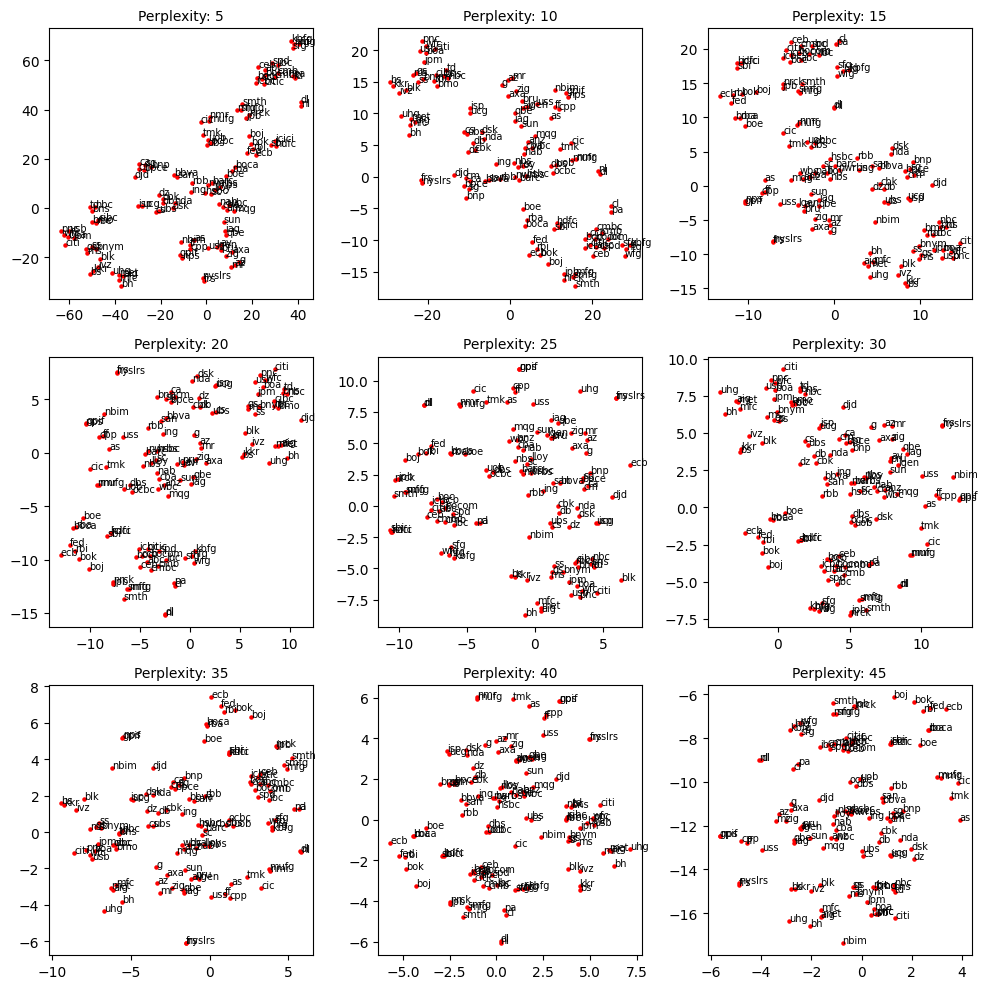

In [15]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
tsne_perplexity_values = [5, 10, 15, 20, 25, 30, 35, 40, 45]

for ax, tsne_perplexity_values in zip(axes.flatten(), tsne_perplexity_values):
    tsne_reducer = TSNE(
        n_components=2,
        perplexity=tsne_perplexity_values,
        max_iter=5000,
        random_state=seed,
        early_exaggeration=12.0,
    )
    sbert_tsne_reduced = tsne_reducer.fit_transform(firm_level_sbert_mean_embedding_matrix)

    ax.scatter(
        sbert_tsne_reduced[:, 0],
        sbert_tsne_reduced[:, 1],
        c="red",
        alpha=1,
        s=5,
    )
    for i, txt in enumerate(firm_list):
        ax.annotate(
            text=txt,
            xy=(sbert_tsne_reduced[:, 0][i] + 0, sbert_tsne_reduced[:, 1][i] + 0),
            fontsize=7,
        )
    ax.set_title(f"Perplexity: {tsne_perplexity_values}", fontsize=10)
    # ax.grid()

plt.tight_layout()
plt.savefig(
    Path("../../../tex_source/plots/plots_appendix/sbert_d_reduc_tsne.pdf"), format="pdf"
)
plt.show()

#### UMAP

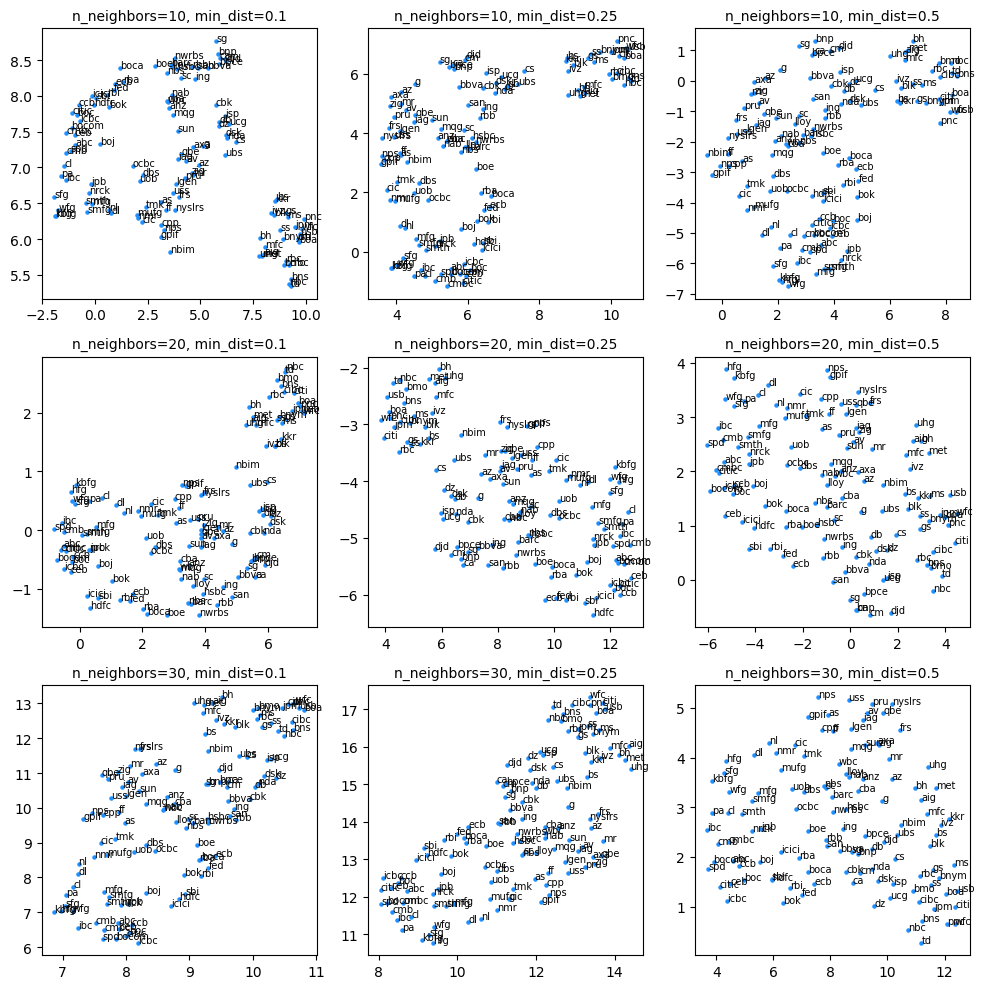

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
umap_n_neighbors = [10, 20, 30]
umap_min_dist = [0.1, 0.25, 0.5]
umap_parameter_values = [(n, d) for n in umap_n_neighbors for d in umap_min_dist]

for ax, umap_parameter_values in zip(axes.flatten(), umap_parameter_values):
    umap_reducer = umap.UMAP(
        n_neighbors=umap_parameter_values[0],
        min_dist=umap_parameter_values[1],
        n_components=2,
        random_state=np.random.RandomState(9),
        n_jobs=1,
    )
    sbert_umap_reduced = umap_reducer.fit_transform(firm_level_sbert_mean_embedding_matrix)

    ax.scatter(
        sbert_umap_reduced[:, 0],
        sbert_umap_reduced[:, 1],
        c="dodgerblue",
        alpha=1,
        s=5,
    )

    for i, txt in enumerate(firm_list):
        ax.annotate(
            text=txt,
            xy=(sbert_umap_reduced[:, 0][i] + 0, sbert_umap_reduced[:, 1][i] + 0),
            fontsize=7,
        )

    ax.set_title(
        f"n_neighbors={umap_parameter_values[0]}, min_dist={umap_parameter_values[1]}",
        fontsize=10,
    )
    # ax.grid().

plt.tight_layout()
plt.savefig(
    Path("../../../tex_source/plots/plots_appendix/sbert_d_reduc_umap.pdf"), format="pdf"
)
plt.show()

### SBERT MeanShift Clustering with UMAP

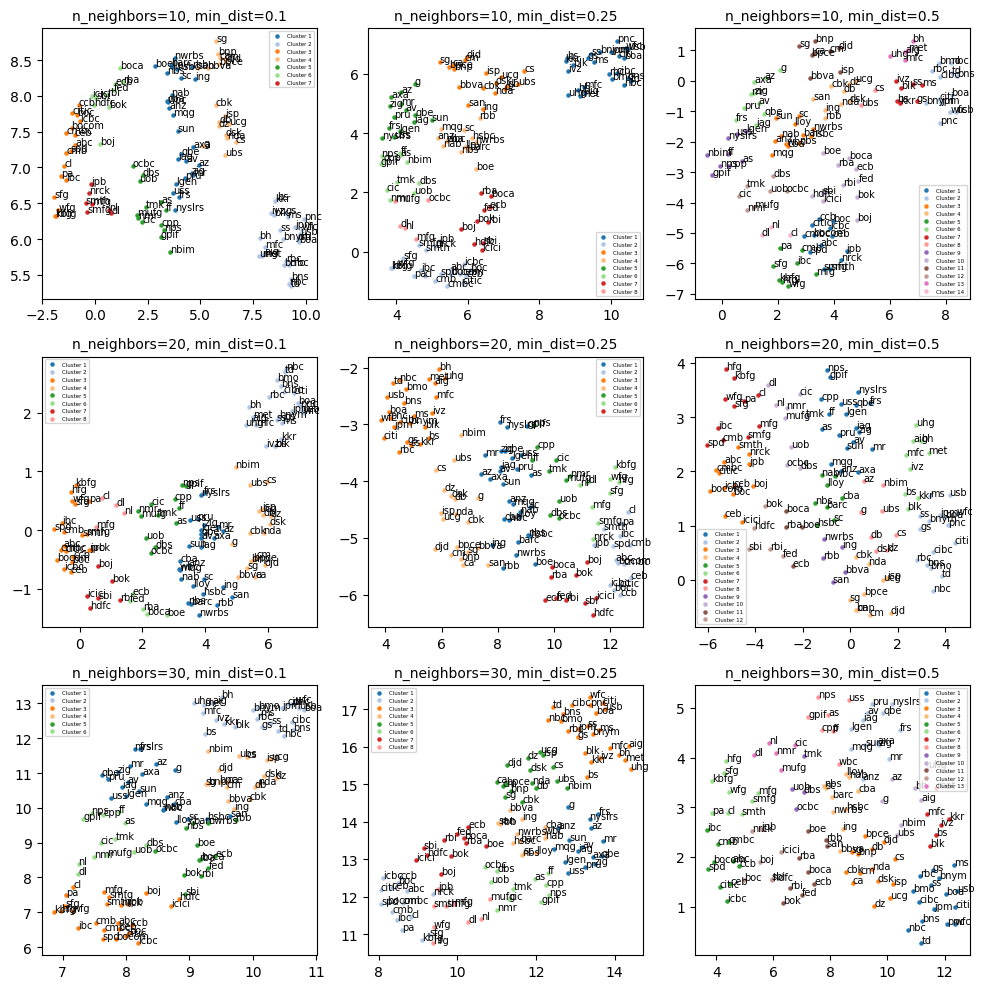

In [17]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
umap_n_neighbors = [10, 20, 30]
umap_min_dist = [0.1, 0.25, 0.5]
umap_parameter_values = [(n, d) for n in umap_n_neighbors for d in umap_min_dist]

for ax, umap_parameter_values in zip(axes.flatten(), umap_parameter_values):
    umap_reducer = umap.UMAP(
        n_neighbors=umap_parameter_values[0],
        min_dist=umap_parameter_values[1],
        n_components=2,
        random_state=seed,
        n_jobs=1,
    )
    sbert_umap_reduced = umap_reducer.fit_transform(firm_level_sbert_mean_embedding_matrix)
    meanshift_sbert_umap = MeanShift(bandwidth=1, cluster_all=True).fit(sbert_umap_reduced)
    labels_meanshift_sbert_umap = meanshift_sbert_umap.labels_

    unique_labels = np.unique(labels_meanshift_sbert_umap)
    cmap = plt.get_cmap('tab20')
    for color_idx, label in enumerate(unique_labels):
        idx = [i for i, val in enumerate(labels_meanshift_sbert_umap) if val == label]
        ax.scatter(
        sbert_umap_reduced[idx, 0],
        sbert_umap_reduced[idx, 1],
        color=cmap(color_idx),
        label=f"Cluster {label+1}",
        alpha=1,
        s=5)

    for i, txt in enumerate(firm_list):
        ax.annotate(
            text=txt,
            xy=(sbert_umap_reduced[:, 0][i] + 0, sbert_umap_reduced[:, 1][i] + 0),
            fontsize=7,
        )

    ax.set_title(
        f"n_neighbors={umap_parameter_values[0]}, min_dist={umap_parameter_values[1]}",
        fontsize=10,
    )
    ax.legend(prop = { "size": 4}, loc ="best")
    # ax.grid().

plt.tight_layout()
plt.savefig(
    Path("../../../tex_source/plots/plots_result/sbert_d_reduc_umap_meanshift.pdf"), format="pdf"
)
plt.show()

### SBERT MeanShift Clustering with UMAP: Best Result

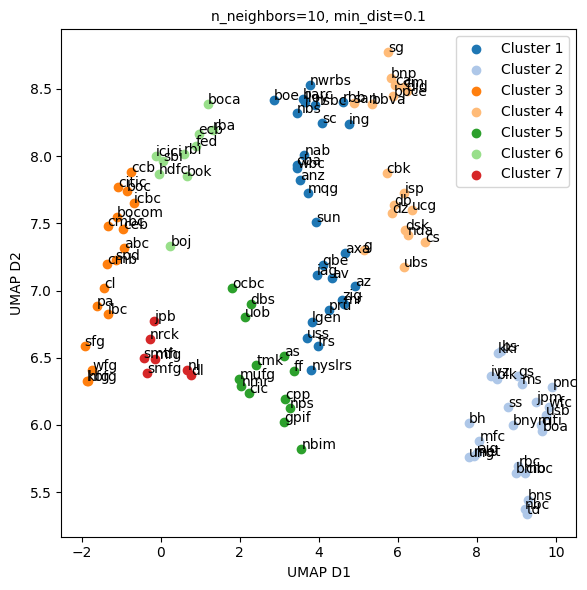

{'Cluster 1': 'anz, av, axa, az, barc, boe, cba, frs, hsbc, iag, ing, lgen, lloy, mqg, mr, nab, nbs, nwrbs, nyslrs, pru, qbe, rbb, sc, sun, uss, wbc, zig',
 'Cluster 2': 'aig, bh, blk, bmo, bns, bnym, boa, bs, cibc, citi, gs, ivz, jpm, kkr, met, mfc, ms, nbc, pnc, rbc, ss, td, uhg, usb, wfc',
 'Cluster 3': 'abc, boc, bocom, ccb, ceb, citic, cl, cmb, cmbc, hfg, ibc, icbc, kbfg, pa, sfg, spd, wfg',
 'Cluster 4': 'bbva, bnp, bpce, ca, cbk, cm, cs, db, djd, dsk, dz, g, isp, nda, san, sg, ubs, ucg',
 'Cluster 5': 'as, cic, cpp, dbs, ff, gpif, mufg, nbim, nmr, nps, ocbc, tmk, uob',
 'Cluster 6': 'boca, boj, bok, ecb, fed, hdfc, icici, rba, rbi, sbi',
 'Cluster 7': 'dl, jpb, mfg, nl, nrck, smfg, smth'}

In [18]:
best_n_neighbors = 10
best_min_dist = 0.1

umap_reducer = umap.UMAP(
    n_neighbors=best_n_neighbors,
    min_dist=best_min_dist,
    n_components=2,
    random_state=seed,
    n_jobs=1,
)
sbert_umap_reduced = umap_reducer.fit_transform(firm_level_sbert_mean_embedding_matrix)
meanshift_sbert_umap = MeanShift(bandwidth=1, cluster_all=True).fit(sbert_umap_reduced)
labels_meanshift_sbert_umap = meanshift_sbert_umap.labels_

plt.figure(figsize=(6, 6))
ax = plt.gca()
unique_labels = np.unique(labels_meanshift_sbert_umap)
cmap = plt.get_cmap("tab20")
meanshift_sbert_umap_best_cluster_result = {}
for color_idx, label in enumerate(unique_labels):
    idx = [i for i, val in enumerate(labels_meanshift_sbert_umap) if val == label]
    meanshift_sbert_umap_best_cluster_result[f"Cluster {label+1}"] = idx
    ax.scatter(
        sbert_umap_reduced[idx, 0],
        sbert_umap_reduced[idx, 1],
        color=cmap(color_idx),
        label=f"Cluster {label+1}",
    )

for i, txt in enumerate(firm_list):
    ax.annotate(txt, (sbert_umap_reduced[:, 0][i] + 0, sbert_umap_reduced[:, 1][i] + 0))

plt.title(
        f"n_neighbors={best_n_neighbors}, min_dist={best_min_dist}",
        fontsize=10,)
plt.legend()
plt.xlabel("UMAP D1")
plt.ylabel("UMAP D2")
plt.tight_layout()
plt.savefig(
    Path("../../../tex_source/plots/plots_result/sbert_d_reduc_umap_meanshift_best.pdf"), format="pdf"
)
plt.show()

for cluster in meanshift_sbert_umap_best_cluster_result.keys():
    meanshift_sbert_umap_best_cluster_result[cluster] = [index_to_firm_map[firm_idx] for firm_idx in meanshift_sbert_umap_best_cluster_result[cluster]] 

meanshift_sbert_umap_best_cluster_result_joined={}
for cluster in meanshift_sbert_umap_best_cluster_result.keys():
    meanshift_sbert_umap_best_cluster_result_joined[cluster] = ", ".join(meanshift_sbert_umap_best_cluster_result[cluster])
meanshift_sbert_umap_best_cluster_result_joined

In [19]:
meanshift_sbert_umap_best_cluster_result_df = pd.DataFrame.from_dict(
    meanshift_sbert_umap_best_cluster_result_joined, orient="index"
)
meanshift_sbert_umap_best_cluster_result_df.reset_index(inplace=True)
meanshift_sbert_umap_best_cluster_result_df.columns = ["Cluster", "Financial Institution"]
meanshift_sbert_umap_best_cluster_result_df

meanshift_sbert_umap_best_cluster_result_df.style.hide().format(na_rep="").set_table_styles([
    {'selector': 'small', 'props': ':;'}], overwrite=False).to_latex(
    buf="../../../tex_source/tables/tables_result/meanshift_sbert_umap_best_cluster_result_table.tex",
    caption="SBERT Mean Shift Clustering (UMAP) Best Result Table",
    label="tab:meanshift_sbert_umap_best_cluster_result_table",
    encoding="utf-8",
    hrules=True,
    position_float="centering",
    position="H",
    column_format="lp{15cm}",
)
# {'selector': 'small', 'props': ':;'}
# {'selector': 'fontsize', 'props': ':{11pt}{13pt}\selectfont;'}

## SBERT Embedding Clusters via Network-Based Method

### SBERT Louvain Community Detection

In [20]:
sbert_cosine_similarity_matrix = compute_cosine_similarity_matrix(firm_level_sbert_mean_embedding_matrix)
sbert_cosine_similarity_matrix_exp_scaled = exp_scale_to_df(sbert_cosine_similarity_matrix, firm_list)
sbert_cosine_similarity_matrix = pd.DataFrame(sbert_cosine_similarity_matrix, columns=firm_list, index=firm_list) # for embedding comparison later

sbert_cosine_similarity_G_weighted = create_weighted_graph_from_df(sbert_cosine_similarity_matrix_exp_scaled)

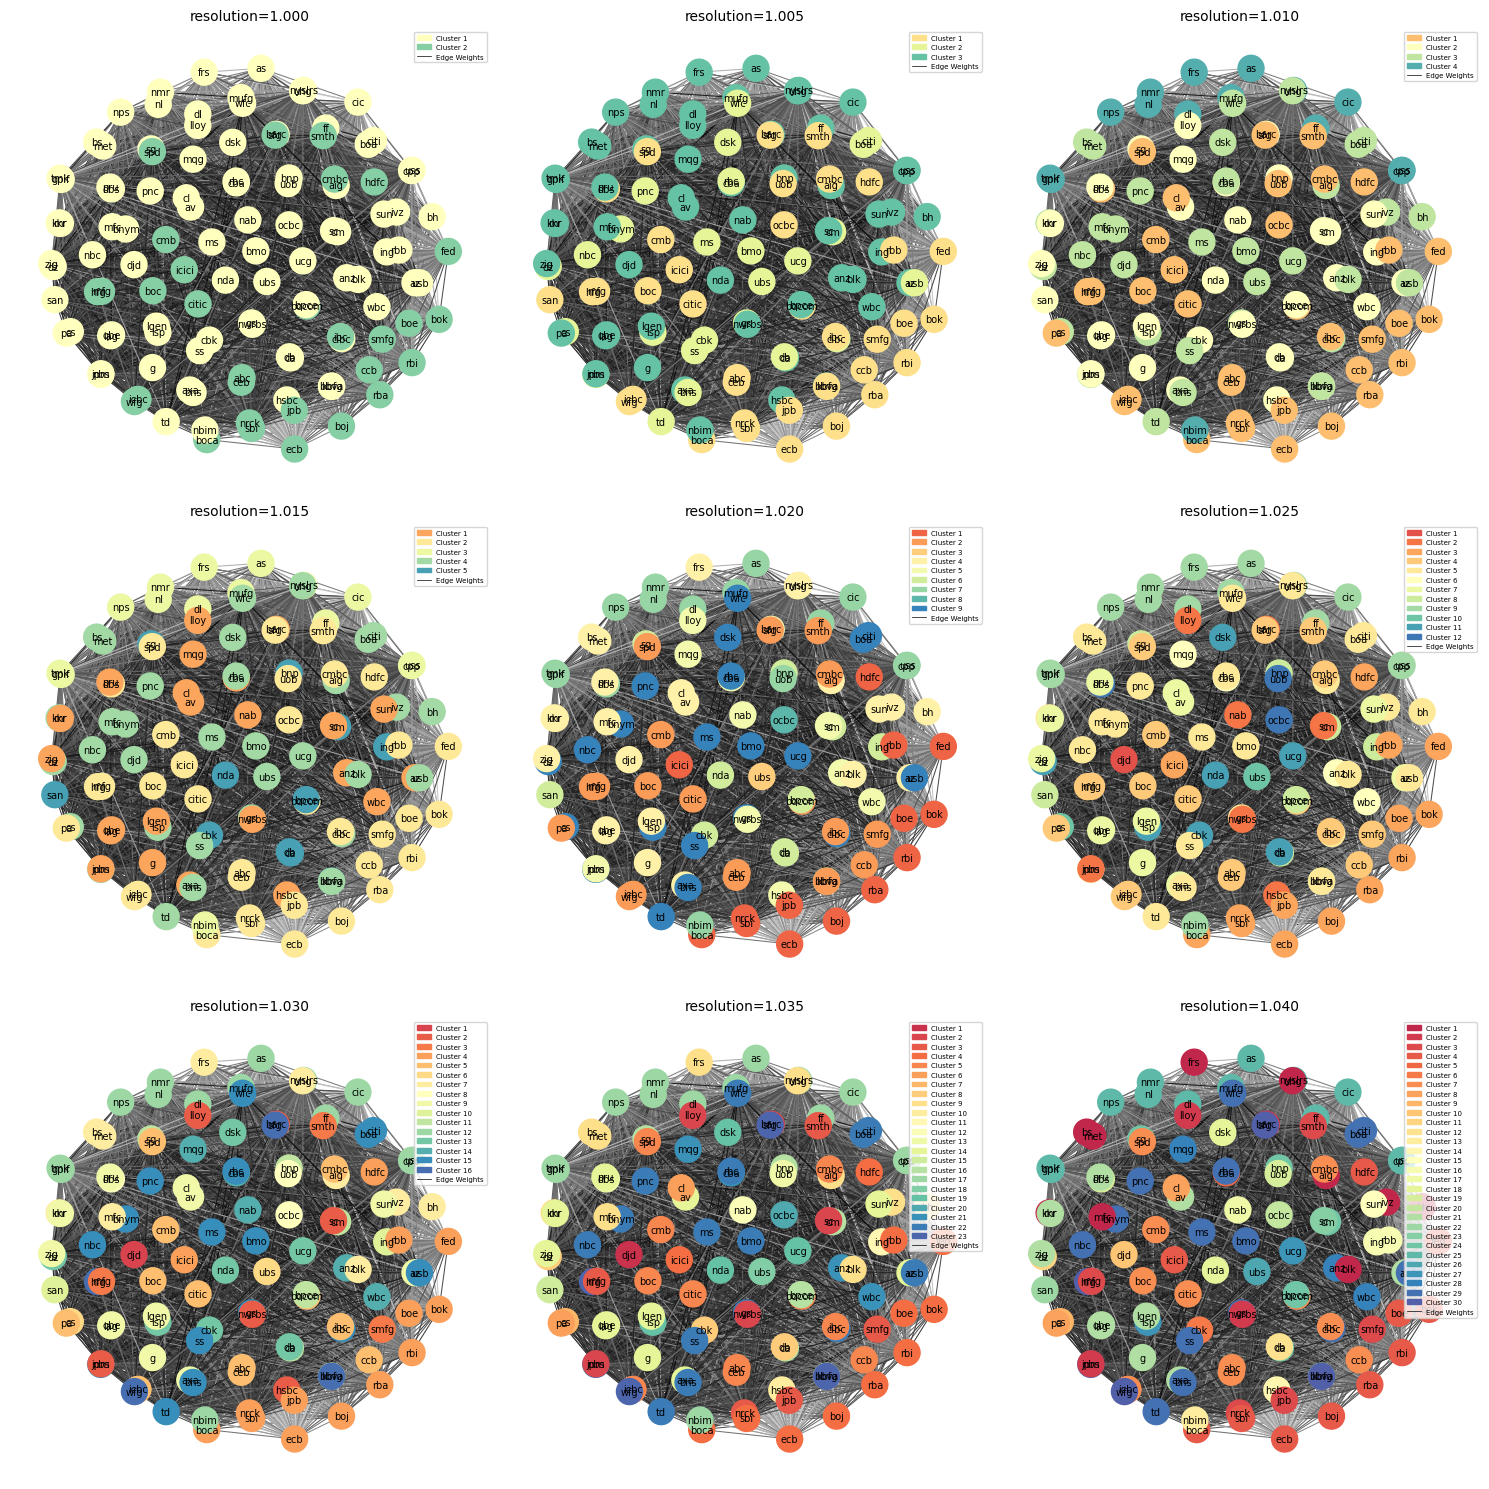

In [21]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

resolution_values = np.linspace(1, 1.04, 9)

# different louvain_communities resolution values plot
for ax, resolution in zip(axes.flatten(), resolution_values):
    sbert_louvain_communities = nx.community.louvain_communities(sbert_cosine_similarity_G_weighted, weight="weight", seed=seed, resolution=resolution)
    edge_weights_dict = nx.get_edge_attributes(sbert_cosine_similarity_G_weighted, 'weight')
    weights = [edge_weights_dict[edge] for edge in sbert_cosine_similarity_G_weighted.edges()]
    
    num_communities = len(sbert_louvain_communities)
    exclude_first_n_color = 2
    colors = [
        plt.cm.Spectral(i / (num_communities + exclude_first_n_color))
        for i in range(num_communities + exclude_first_n_color)
    ][
        exclude_first_n_color : num_communities + exclude_first_n_color
    ]  # Create a color map for the communities, adjusted to exclude the first n color (too dark)

    # Create a dictionary to map nodes to their community colors
    node_color_map = {}
    sbert_louvain_communities_with_color_and_label = {}
    for community_index, community in enumerate(sbert_louvain_communities):
        sbert_louvain_communities_with_color_and_label[f"Cluster {community_index+1}"] = {"color": colors[community_index], "nodes": community}
        for node in community:
            node_color_map[node] = colors[community_index]
    node_colors = [node_color_map[node] for node in sbert_cosine_similarity_G_weighted.nodes()]

    # Generate layout for the graph
    pos = nx.spring_layout(sbert_cosine_similarity_G_weighted, seed=seed, iterations=5000, threshold=1e-9)
    
    # Plot the graph
    nx.draw(
        sbert_cosine_similarity_G_weighted,
        pos,
        with_labels=True,
        node_size=350,
        node_color=node_colors,
        font_size=7,
        font_weight="normal",
        font_color="black",
        edge_color=weights,
        edge_cmap=plt.cm.binary,
        width=0.75,
        ax=ax
    )

    patches = [mpatches.Patch(color=color['color'], label=label) for label, color in sbert_louvain_communities_with_color_and_label.items()]
    edge_line = mlines.Line2D([], [], color='black', linewidth=0.5, label='Edge Weights') # add edge weight line to legend

    ax.legend(handles=patches+[edge_line], prop={"size": 5}, loc="upper right")
    ax.set_title(f"resolution={resolution:.3f}", fontsize=10)

plt.tight_layout()
plt.savefig(
    Path("../../../tex_source/plots/plots_result/sbert_network_louvain.pdf"), format="pdf"
)
plt.show()

### SBERT Louvain Community Detection: Best Result

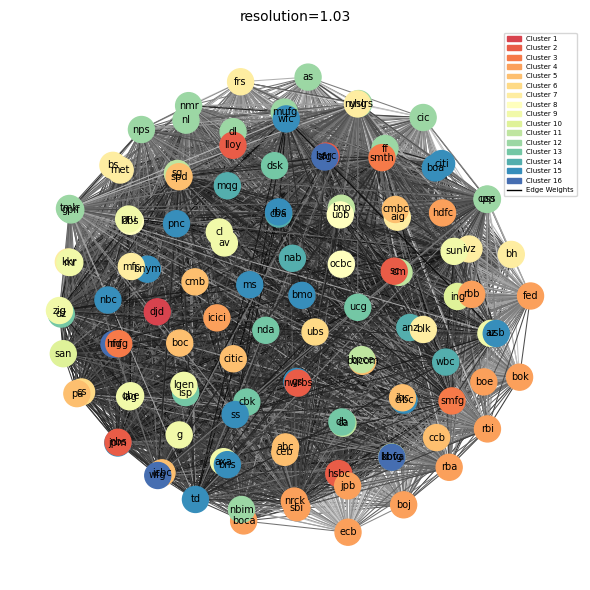

{'Cluster 1': 'djd',
 'Cluster 2': 'nbs, barc, lloy, nwrbs, sc, hsbc',
 'Cluster 3': 'smth, mfg, smfg',
 'Cluster 4': 'bok, icici, fed, sbi, rbb, boe, rbi, ecb, boj, nrck, boca, rba, jpb, hdfc',
 'Cluster 5': 'cmb, ibc, ccb, citic, icbc, ceb, cmbc, pa, bocom, spd, boc, abc',
 'Cluster 6': 'cs, ubs',
 'Cluster 7': 'ivz, mfc, bh, kkr, aig, bs, frs, blk, met, uhg',
 'Cluster 8': 'uob, ocbc, dbs',
 'Cluster 9': 'pru, iag, g, mr, lgen, qbe, az, cl, av, axa, sun, zig',
 'Cluster 10': 'bbva, san, ing',
 'Cluster 11': 'ca, sg, bnp, bpce, cm',
 'Cluster 12': 'as, gpif, tmk, mufg, uss, cic, nps, nmr, ff, cpp, nyslrs, nbim, dl, nl',
 'Cluster 13': 'isp, cbk, ucg, nda, db, dz, dsk',
 'Cluster 14': 'mqg, nab, wbc, anz, cba',
 'Cluster 15': 'jpm, pnc, usb, rbc, bns, bnym, cibc, ms, boa, ss, citi, wfc, td, gs, nbc, bmo',
 'Cluster 16': 'kbfg, sfg, hfg, wfg'}

In [22]:
best_resolution = 1.03

sbert_louvain_best_communities = nx.community.louvain_communities(sbert_cosine_similarity_G_weighted, weight="weight", seed=seed, resolution=best_resolution)
edge_weights_dict = nx.get_edge_attributes(sbert_cosine_similarity_G_weighted, 'weight')
weights = [edge_weights_dict[edge] for edge in sbert_cosine_similarity_G_weighted.edges()]

sbert_louvain_best_num_communities = len(sbert_louvain_best_communities)
exclude_first_n_color = 2
colors = [
    plt.cm.Spectral(i / (sbert_louvain_best_num_communities + exclude_first_n_color))
    for i in range(sbert_louvain_best_num_communities + exclude_first_n_color)
][
    exclude_first_n_color : sbert_louvain_best_num_communities + exclude_first_n_color
]  # Create a color map for the communities, adjusted to exclude the first n color (too dark)

# Create a dictionary to map nodes to their community colors
node_color_map = {}
sbert_louvain_best_communities_with_color_and_label = {}
for community_index, community in enumerate(sbert_louvain_best_communities):
    sbert_louvain_best_communities_with_color_and_label[f"Cluster {community_index+1}"] = {"color": colors[community_index], "nodes": community}
    for node in community:
        node_color_map[node] = colors[community_index]
node_colors = [node_color_map[node] for node in sbert_cosine_similarity_G_weighted.nodes()]

# Generate layout for the graph
pos = nx.spring_layout(sbert_cosine_similarity_G_weighted, seed=seed, iterations=5000, threshold=1e-9)

# Plot the graph
plt.figure(figsize=(6, 6))
nx.draw(
    sbert_cosine_similarity_G_weighted,
    pos,
    with_labels=True,
    node_size=350,
    node_color=node_colors,
    font_size=7,
    font_weight="normal",
    font_color="black",
    edge_color=weights,
    edge_cmap=plt.cm.binary,
    width=0.75,
    ax=plt.gca()
)

patches = [mpatches.Patch(color=color['color'], label=label) for label, color in sbert_louvain_best_communities_with_color_and_label.items()]
edge_line = mlines.Line2D([], [], color='black', linewidth=1, label='Edge Weights') # add edge weight line to legend

plt.legend(handles=patches+[edge_line], prop={"size": 5}, loc="upper right")
plt.title(f"resolution={best_resolution}", fontsize=10)
plt.tight_layout()
plt.savefig(
Path("../../../tex_source/plots/plots_result/sbert_network_louvain_best.pdf"), format="pdf"
)
plt.show()

louvain_sbert_best_cluster_result = {key: value['nodes'] for key, value in sbert_louvain_best_communities_with_color_and_label.items()}
louvain_sbert_best_cluster_result_joined={}
for cluster in louvain_sbert_best_cluster_result.keys():
    louvain_sbert_best_cluster_result_joined[cluster] = ", ".join(louvain_sbert_best_cluster_result[cluster])
louvain_sbert_best_cluster_result_joined

In [23]:
louvain_sbert_best_cluster_result_df = pd.DataFrame.from_dict(
    louvain_sbert_best_cluster_result_joined, orient="index"
)
louvain_sbert_best_cluster_result_df.reset_index(inplace=True)
louvain_sbert_best_cluster_result_df.columns = ["Cluster", "Financial Institution"]
louvain_sbert_best_cluster_result_df.style.hide().format(na_rep="").set_table_styles([
    {'selector': 'small', 'props': ':;'}], overwrite=False).to_latex(
    buf="../../../tex_source/tables/tables_result/louvain_sbert_best_cluster_result_table.tex",
    caption="SBERT Louvain Community Detection Best Result Table",
    label="tab:louvain_sbert_best_cluster_result_table",
    encoding="utf-8",
    hrules=True,
    position_float="centering",
    position="H",
    column_format="lp{15cm}",
)
# {'selector': 'small', 'props': ':;'}
# {'selector': 'fontsize', 'props': ':{11pt}{13pt}\selectfont;'}

# Word2Vec Embedding vs. SBERT Embedding

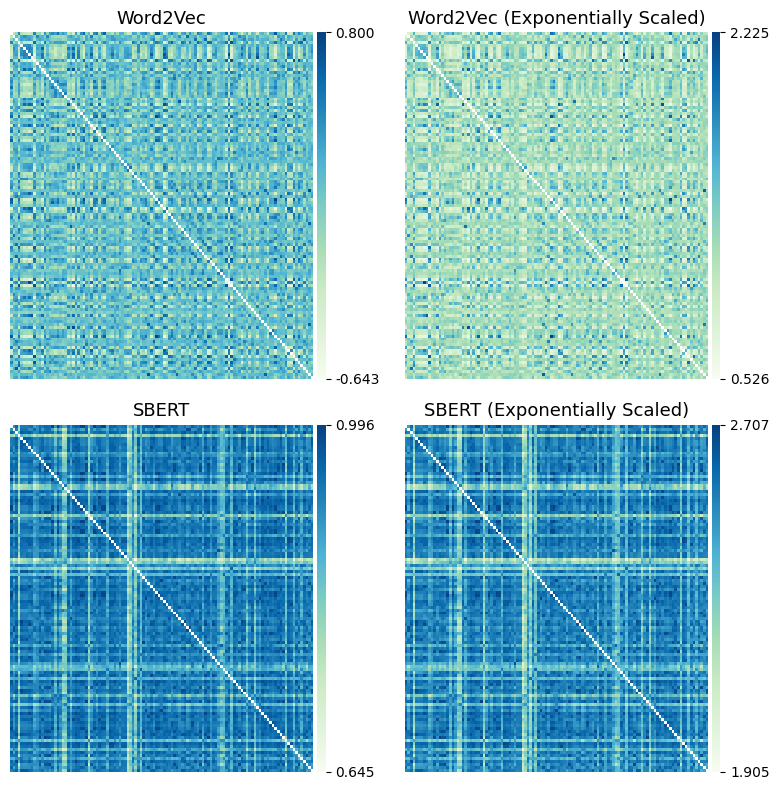

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

sns.heatmap(
    w2v_cosine_similarity_matrix,
    cmap="GnBu",
    cbar_kws={"shrink": 1, "aspect": 40, "pad": 0.01, 
              "ticks": [w2v_cosine_similarity_matrix.min().min(), w2v_cosine_similarity_matrix.max().max()],
              "format": "%.3f"},
    ax=axes[0,0],
)
axes[0,0].set_title('Word2Vec', fontsize=13)
axes[0,0].set_xticks([])
axes[0,0].set_yticks([])

sns.heatmap(
    w2v_cosine_similarity_matrix_exp_scaled,
    cmap="GnBu",
    cbar_kws={"shrink": 1, "aspect": 40, "pad": 0.01, 
              "ticks": [w2v_cosine_similarity_matrix_exp_scaled.min().min(), w2v_cosine_similarity_matrix_exp_scaled.max().max()],
              "format": "%.3f"},
    ax=axes[0,1],
)
axes[0,1].set_title('Word2Vec (Exponentially Scaled)', fontsize=13)
axes[0,1].set_xticks([])
axes[0,1].set_yticks([])

sns.heatmap(
    sbert_cosine_similarity_matrix,
    cmap="GnBu",
    cbar_kws={"shrink": 1, "aspect": 40, "pad": 0.01, 
              "ticks": [sbert_cosine_similarity_matrix.min().min(), sbert_cosine_similarity_matrix.max().max()],
              "format": "%.3f"},
    ax=axes[1,0],
)
axes[1,0].set_title('SBERT' , fontsize=13)
axes[1,0].set_xticks([])
axes[1,0].set_yticks([])

sns.heatmap(
    sbert_cosine_similarity_matrix_exp_scaled,
    cmap="GnBu",
    cbar_kws={"shrink": 1, "aspect": 40, "pad": 0.01, 
              "ticks": [sbert_cosine_similarity_matrix_exp_scaled.min().min(), sbert_cosine_similarity_matrix_exp_scaled.max().max()],
              "format": "%.3f"},
    ax=axes[1,1],
)
axes[1,1].set_title('SBERT (Exponentially Scaled)' , fontsize=13)
axes[1,1].set_xticks([])
axes[1,1].set_yticks([])

plt.tight_layout()
plt.savefig(
    Path("../../../tex_source/plots/plots_result/w2v_vs_sbert_cosine_sim.pdf"), format="pdf"
)
plt.show()